In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import numpy as np
from PIL import Image         
import cv2                 
import matplotlib.pyplot as plt
from os import getcwd
import csv
# Fix error with TF and Keras
import tensorflow as tf

## Preprocessing

All preprocessing steps need to be don in driver.py too

In [67]:
def process_img_for_visualization(image, angle, pred_angle):
    '''
    Converts back to RGB, adds steering angle to image together with predicted angle if given.
    '''    
    # Transform image back to RGB
    img = cv2.cvtColor(image, cv2.COLOR_YUV2RGB)

    # Add steering angle as text in the top left corner
    cv2.putText(img, 'Angle = %.2f' %  angle, org=(2,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, \
                fontScale=1, color=(255,255,255), thickness=2)
    
    # Add line representing the steering angle
    height, width = img.shape[0:2]
    cv2.line(img,(int(width/2),int(height)),(int(width/2+angle*width/4),int(height/2)),(0,0,255),thickness=4)
    
    # If predicted angle is given, add it to the image in a different color for comparison
    if pred_angle is not None:
        cv2.line(img,(int(width/2),int(height)),(int(width/2+pred_angle*width/4),int(height/2)),(255,0,0),thickness=4)
        
    return img
    
def visualize_dataset(image_batch,angle_batch,predicted_angle=None):
    '''
    Returns the transformed images with the steering angle 
    '''
    new_images = []
    for i in range(len(image_batch)):
        if predicted_angle is not None:
            img = process_img_for_visualization(image_batch[i], angle_batch[i], predicted_angle[i])
        else: 
            img = process_img_for_visualization(image_batch[i], angle_batch[i], None)
        
        new_images.append(img)
    
    return np.array(new_images)

def preprocess_image(img):
    '''
    Adds gaussian blur and transforms BGR to YUV. 
    '''
    new_img = cv2.GaussianBlur(img, (3,3), 0)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

def random_distortion(img):
    ''' 
    Adds random distortion to training dataset: random brightness, shadows and a random vertical shift 
    of the horizon position
    '''
    new_img = img.astype(float)
    
    # Add random brightness
    value = np.random.randint(-28, 28)
    new_img[:,:,0] = np.minimum(np.maximum(new_img[:,:,0],0),255)
    
    # Add random shadow covering the entire height but random width
    img_height, img_width = new_img.shape[0:2]
    middle_point = np.random.randint(0,img_width)
    darkening = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:middle_point,0] *= darkening
    else:
        new_img[:,middle_point:img_width,0] *= darkening
        
    # Applying a perspective transform at the beginning of the horizon line
    horizon = 2*img_height/5    # Assumes horizon to be located at 2/5 of image height
    v_shift = np.random.randint(-img_height/8,img_height/8)   # Shifting horizon by up to 1/8
    
    # First points correspond to a rectangle surrounding the image below the horizon line
    pts1 = np.float32([[0,horizon],[img_width,horizon],[0,img_height],[img_width,img_height]])
    # Second set of points correspond to same rectangle plus a random vertical shift
    pts2 = np.float32([[0,horizon+v_shift],[img_width,horizon+v_shift],[0,img_height],[img_width,img_height]])
    
    # Getting the perspective transformation
    M = cv2.getPerspectiveTransform(pts1,pts2)   
    # pplying the perspective transformation
    new_img = cv2.warpPerspective(new_img,M,(img_width,img_height), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

def generator(image_paths, steering_angles, batch_size=32, validation_flag=False):
    '''
    Training batches generator. Does not distort the images if "validation_flag" is set to True
    '''
    num_samples = len(image_paths)
    while 1:  
        image_paths, steering_angles = shuffle(image_paths, steering_angles)
        for offset in range(0, num_samples, batch_size):
            batch_images = image_paths[offset:offset+batch_size]
            batch_angles = steering_angles[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_angle ,batch_image in zip(batch_angles,batch_images):
                img = cv2.imread(batch_image)
                img = preprocess_image(img)
                
                if not validation_flag:
                    img = random_distortion(img)

                # Randomly flipping the image to augment data
                # Only augmenting rare examples (angle > ~0.3)
                if abs(batch_angle) > 0.3 and np.random.random_sample() >= 0.5:
                    img = cv2.flip(img, 1)
                    batch_angle *= -1
                
                images.append(img)
                angles.append(batch_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)
            

def generate_data(image_paths, angles, batch_size=20, validation_flag=False):
    '''
    Loads, preprocess and distorts images batch.
    If 'validation_flag' is true the image is not distorted.
    '''
    image_batch = []
    label_batch = []
    image_paths, angles = shuffle(image_paths, angles)
    for i in range(batch_size):
        img = cv2.imread(image_paths[i])
        angle = angles[i]
        img = preprocess_image(img)
        if not validation_flag:
            img = random_distortion(img)
        image_batch.append(img)
        label_batch.append(angle)
    return np.array(image_batch), np.array(label_batch)

In [3]:
# Name of folders containing data provided by Udacity and data collected by myself
data_folders = ['./data','./data2']

image_paths = []
steering_angles = []

minimum_speed = 20.0

speeds = []
for data_folder in data_folders:
    with open(data_folder + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if line[0] == 'center':
                # Ignore header
                continue
            else:
                speeds.append(float(line[6]))
                if float(line[6]) > minimum_speed:
                    # get center image path and angle
                    source_path = data_folder + '/IMG/'+line[0].split('/')[-1]
                    image_paths.append(source_path)
                    steering_angles.append(float(line[3]))
                    # get left image path and angle
                    source_path = data_folder + '/IMG/'+line[1].split('/')[-1]
                    image_paths.append(source_path)
                    steering_angles.append(float(line[3])+0.25)
                    # get left image path and angle
                    source_path = data_folder + '/IMG/'+line[2].split('/')[-1]
                    image_paths.append(source_path)
                    steering_angles.append(float(line[3])-0.25)
                
image_paths = np.array(image_paths)
steering_angles = np.array(steering_angles)

print('Samples in dataset:', image_paths.shape[0])

Samples in dataset: 51744


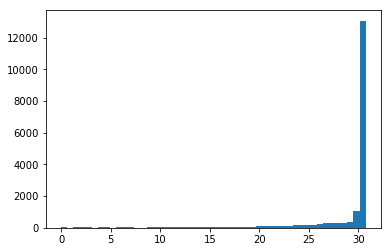

In [4]:
plt.hist(speeds, bins=50)
plt.show()

## Using a histogram to analyze the distribution of training steering angles

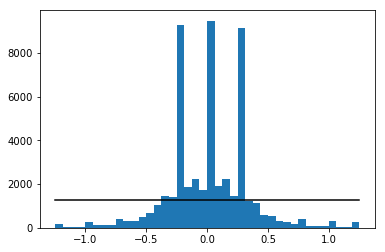

In [5]:
# Number of bins was determined experimentally
num_bins = 40
hist, bins = np.histogram(steering_angles, num_bins)
avg_samples_per_bin = np.mean(hist)
plt.hist(steering_angles, bins=bins)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

In [6]:
# First, determine keep probability for each bin. If number of samples is larger than avg, we will remove
# proportionally to the number of samples above the average; otherwise we keep all samples.
new_target_avg = avg_samples_per_bin * 1.0
keep_probs = []
for i in range(num_bins):
    if hist[i] < new_target_avg:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/new_target_avg))

In [7]:
idx_to_remove = []
for i in range(len(steering_angles)):
    for j in range(num_bins):
        if steering_angles[i] >= bins[j] and steering_angles[i] <= bins[j+1]:
            # Delete with probability 1-keep_prob
            if np.random.random_sample() > keep_probs[j]:
                idx_to_remove.append(i)

In [8]:
image_paths = np.delete(image_paths, idx_to_remove, axis=0)
steering_angles = np.delete(steering_angles, idx_to_remove)

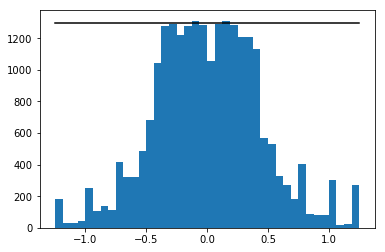

Samples in dataset: 23441


In [9]:
hist, bins = np.histogram(steering_angles, num_bins)
plt.hist(steering_angles, bins=bins)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

print('Samples in dataset:', image_paths.shape[0])

In [160]:
# visualize a single batch of the data
image_batch, label_batch = generate_data(image_paths, steering_angles, batch_size=1)
img_temp = visualize_dataset(image_batch,label_batch)

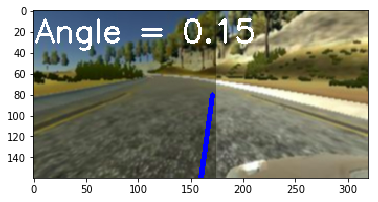

In [161]:
plt.imshow(img_temp[0,:])
plt.show()

In [139]:
def test_horizon_shift(img):
    new_img = img.astype(float)
    img_height, img_width = new_img.shape[0:2]

    # Applying a perspective transform at the beginning of the horizon line
    horizon = 2*img_height/5    # Assumes horizon to be located at 2/5 of image height
    v_shift = np.random.randint(-img_height/8,img_height/8)   # Shifting horizon by up to 1/8
    
    # First points correspond to a rectangle surrounding the image below the horizon line
    pts1 = np.float32([[0,horizon],[img_width,horizon],[0,img_height],[img_width,img_height]])
    # Second set of points correspond to same rectangle plus a random vertical shift
    pts2 = np.float32([[0,horizon+v_shift],[img_width,horizon+v_shift],[0,img_height],[img_width,img_height]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    new_img = cv2.warpPerspective(new_img,M,(img_width,img_height), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

In [140]:
test_img = cv2.imread(image_paths[10])
new_img = test_horizon_shift(test_img)

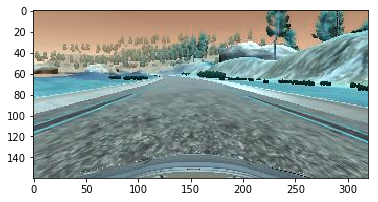

In [141]:
plt.imshow(test_img)
plt.show()

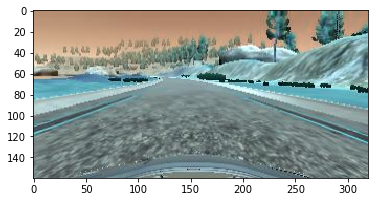

In [142]:
plt.imshow(new_img)
plt.show()

In [68]:
train_generator = generator(image_paths, steering_angles, batch_size=20)

In [73]:
a,b = train_generator.__next__()

In [74]:
a.shape

(20, 160, 320, 3)

In [71]:
a,b = train_generator.__next__()